In [2]:
import pandas as pd
import numpy as np
import configparser
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
import time
# import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [3]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [4]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token, start_date, end_date):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": start_date,
        "ToDate": end_date,
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [5]:
# Define token
token = get_access_token(consumer_id, consumer_secret, private_key)

In [6]:
stock = pd.DataFrame(columns=['TradingDate', 'ClosePrice'])

# Historical data

In [7]:
symb = 'VCB'
date = datetime.today()

for i in range(20):
    end_date = date.strftime("%d/%m/%Y")
    start_date = (date - timedelta(days=30)).strftime("%d/%m/%Y")
    data = get_stock_price(symb, token, start_date, end_date)
    df = pd.DataFrame(data['data'])

    # Ensure correct types
    df['TradingDate'] = pd.to_datetime(df['TradingDate'], dayfirst=True)
    df['ClosePrice'] = pd.to_numeric(df['ClosePrice'], errors='coerce')
    
    df1 = df.loc[df['Symbol'] == symb, ['TradingDate', 'ClosePrice']]

    # Append to master DataFrame
    stock = pd.concat([stock, df1], ignore_index=True)

    # Adjust date back
    date -= timedelta(days=31)

    # Wait before the next request to respect rate limit
    time.sleep(3)  

/tmp/ipykernel_11079/3452342173.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock = pd.concat([stock, df1], ignore_index=True)


KeyboardInterrupt: 

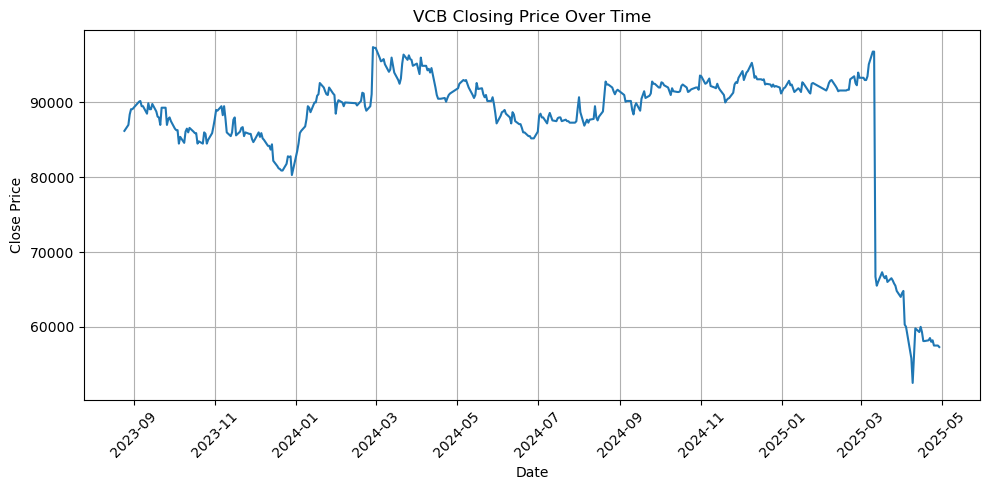

In [ ]:
# Sort by trading date
stock = stock.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock['TradingDate'], stock['ClosePrice'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{symb} Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
stock

# Realtime data

In [ ]:
# Get realtime stock price and info
def get_rt_stock_price(symbol, token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IntradayOhlc"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
    "symbol": symbol,
    "FromDate": datetime.today().strftime("%d/%m/%Y"),
    "ToDate": datetime.today().strftime("%d/%m/%Y"),
    "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [ ]:
rt_stock = get_rt_stock_price('GAS', token)

In [ ]:
rt_stock = pd.DataFrame(data['data'])
rt_stock

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(rt_stock['Time'], rt_stock['Close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'GAS Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
t = None
while True:
    rt = get_rt_stock_price('GAS', token)
    if t == None or rt['data'][0]['Time'] != t:
        print(rt['data'][0])
    t = rt['data'][0]['Time']
    time.sleep(2)

In [ ]:
fig = go.FigureWidget()
fig.add_scatter()
fig

In [ ]:
times = list()
prices = list()

for _ in range(75):
    rt = get_rt_stock_price('GAS', token)
    t = rt['data'][0]['Time']
    times.append(t)  
    price = rt['data'][0]['Close']
    prices.append(int(price))
    fig.data[0].x = times  
    fig.data[0].y = prices  
    time.sleep(2)

# VN Stock

In [2]:
from vnstock import Vnstock, Listing

symbol = 'TPB'
stock = Vnstock().stock(symbol=symbol, source='VCI')
stk = stock.quote.history(start='2019-01-01', end=datetime.today().strftime("%Y-%m-%d"), to_df=True)
stk.tail()

NameError: name 'datetime' is not defined

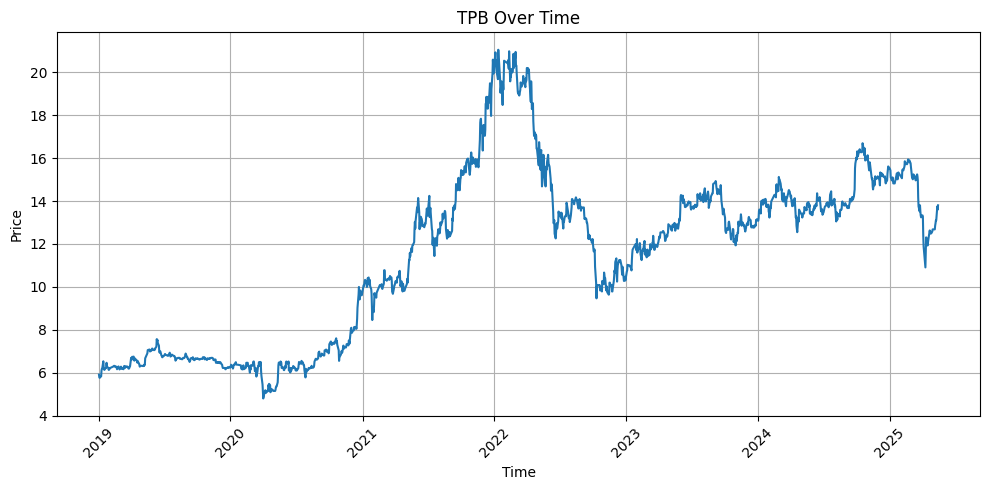

In [8]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{symbol} Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
Listing


AttributeError: type object 'Listing' has no attribute 'stock'

## Differencing

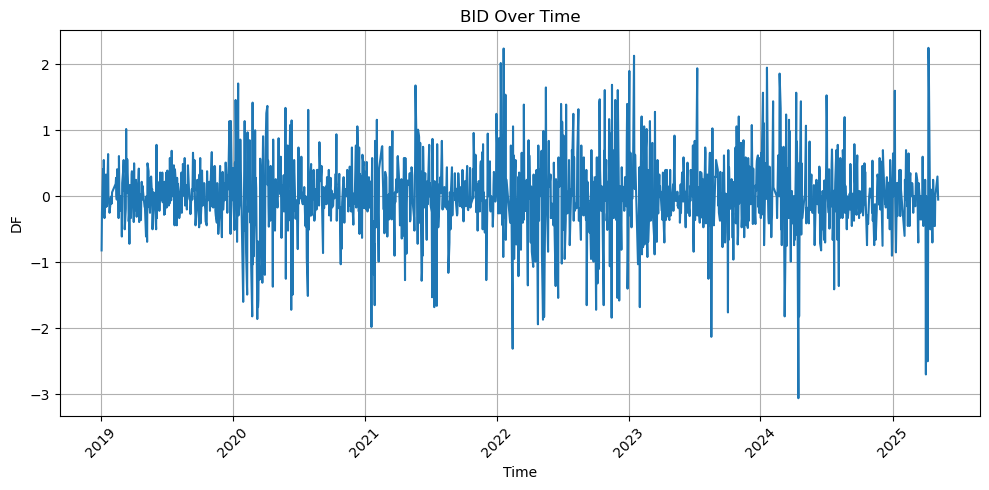

In [13]:
stk['df'] = stk['close'].diff()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['df'])
plt.xlabel('Time')
plt.ylabel('DF')
plt.title(f'{symbol} Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#Adfuller check stationary
adfuller(stk['df'].dropna())[1]

3.693215841965912e-30

## ARIMA

In [9]:
modelARIMA = ARIMA(stk['close'], order=(1, 2, 1))
model_fit = modelARIMA.fit()

# Forecast 
forecast = model_fit.forecast(steps=20)

In [10]:
forecast

1586    13.796572
1587    13.801903
1588    13.806857
1589    13.811827
1590    13.816796
1591    13.821766
1592    13.826735
1593    13.831705
1594    13.836674
1595    13.841643
1596    13.846613
1597    13.851582
1598    13.856552
1599    13.861521
1600    13.866490
1601    13.871460
1602    13.876429
1603    13.881399
1604    13.886368
1605    13.891338
Name: predicted_mean, dtype: float64

# GARCH

In [11]:
# 3. Calculate log returns from price and rescale by 100
log_returns = np.log(stk['close'] / stk['close'].shift(1)).dropna() * 100

# 4. Fit the GARCH(1,1) model to rescaled log returns
model = arch_model(log_returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

# 5. Forecast the next 20 steps
forecast_horizon = 20
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# 6. Get the forecasted mean and variance (volatility), and rescale back
mean_forecast = garch_forecast.mean.iloc[-1].values / 100
variance_forecast = garch_forecast.variance.iloc[-1].values / (100**2)
vol_forecast = np.sqrt(variance_forecast)

# 7. Simulate possible log return paths (using mean and volatility)
simulated_log_returns = np.random.normal(loc=mean_forecast, scale=vol_forecast, size=forecast_horizon)

# 8. Convert forecasted log returns to price path
last_price = stk['close'].iloc[-1]
forecasted_prices = [last_price]
for r in simulated_log_returns:
    forecasted_prices.append(forecasted_prices[-1] * np.exp(r))
forecasted_prices = forecasted_prices[1:]  # Remove the initial last_price

forecasted_prices

[np.float64(13.600037895154882),
 np.float64(13.263484944596472),
 np.float64(12.944657182227445),
 np.float64(12.918096654910538),
 np.float64(13.01401907530026),
 np.float64(13.30986354792164),
 np.float64(13.658461499486805),
 np.float64(13.315863259732582),
 np.float64(13.060095495203417),
 np.float64(13.32113525891363),
 np.float64(13.392138790857073),
 np.float64(14.045849983322237),
 np.float64(14.147404370951287),
 np.float64(13.917532277951853),
 np.float64(13.869190034948385),
 np.float64(14.239218811313568),
 np.float64(14.461017279384828),
 np.float64(14.274720840865815),
 np.float64(14.016217069861085),
 np.float64(14.265096331329108)]

# Log return Analysis 

In [9]:
stk['log_return'] = np.log(stk['close'] / stk['close'].shift(1))

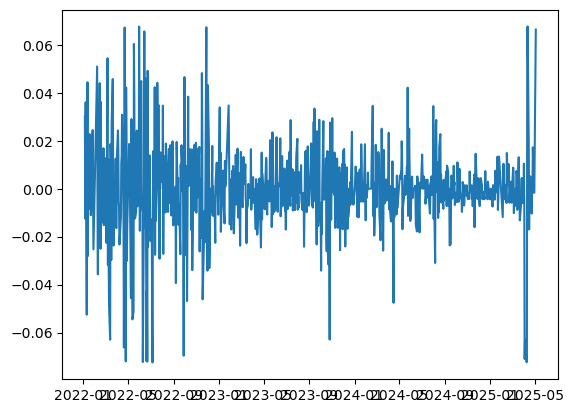

In [12]:
plt.plot(stk['time'], stk['log_return'])

In [4]:
stock.quote.intraday(symbol='VCB').tail(20)

,time,price,volume,match_type,id
80,2025-05-13 09:48:34+07:00,57.3,400,Buy,296123358
81,2025-05-13 09:48:39+07:00,57.3,400,Buy,296123566
82,2025-05-13 09:48:41+07:00,57.3,2000,Buy,296123650
83,2025-05-13 09:48:42+07:00,57.3,500,Buy,296123682
84,2025-05-13 09:48:50+07:00,57.2,700,Sell,296124054
85,2025-05-13 09:48:50+07:00,57.2,100,Sell,296124055
86,2025-05-13 09:48:50+07:00,57.2,1000,Sell,296124056
87,2025-05-13 09:48:51+07:00,57.2,100,Sell,296124073
88,2025-05-13 09:48:53+07:00,57.3,1000,Buy,296124174
89,2025-05-13 09:49:09+07:00,57.2,200,Sell,296124810


In [9]:
stk = stock.quote.intraday(symbol=symbol, to_df=True)
last_buy = stk[stk['match_type'] == 'Buy'].iloc[-1]
last_sell = stk[stk['match_type'] == 'Sell'].iloc[-1]

last_buy_price = last_buy['price']
last_sell_price = last_sell['price']
last_buy_vol = last_buy['volume']
last_sell_vol = last_sell['volume']


In [9]:
df = stock.quote.intraday(symbol='VCB', raw=True)

# Nếu cột volume có kiểu float hay string có ".0"
df['volume'] = df['volume'].astype(float).astype(int)

print(df.tail(20))

RetryError: RetryError[<Future at 0x7e4433d9b620 state=finished raised TypeError>]

In [12]:
import requests

TOKEN = '8092343811:AAFMv0H66W0B1qzvwwoI5BNmCdMyC3rrHHk'
url = f"https://api.telegram.org/bot{TOKEN}/getUpdates"

response = requests.get(url)
print(response.json())

{'ok': True, 'result': [{'update_id': 681663065, 'message': {'message_id': 2, 'from': {'id': 817649025, 'is_bot': False, 'first_name': 'Thang', 'last_name': 'Winston', 'language_code': 'en'}, 'chat': {'id': 817649025, 'first_name': 'Thang', 'last_name': 'Winston', 'type': 'private'}, 'date': 1745911537, 'text': 'alo'}}]}


In [13]:
def send_telegram_message(message, token, chat_id):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message
    }
    response = requests.post(url, data=payload)
    return response

In [ ]:
# Setup
BOT_TOKEN = TOKEN
CHAT_ID = '817649025'

# Send a test message
send_telegram_message("Hello from Jupyter Notebook!", BOT_TOKEN, CHAT_ID)

<Response [200]>

In [3]:
symbol = 'VCB'

while True: 
    stk = stock.quote.intraday(symbol=symbol, to_df=True)
    last_buy = stk[stk['match_type'] == 'Buy'].tail(1)
    last_buy_price = float(last_buy['price'].iloc[0])
    last_sell = stk[stk['match_type'] == 'Sell'].tail(1)
    last_sell_price = float(last_sell['price'].iloc[0])
    send_telegram_message(f"{symbol} Buy: {last_buy_price}   Sell: {last_sell_price}", BOT_TOKEN, CHAT_ID)
    time.sleep(5)

NameError: name 'send_telegram_message' is not defined

In [22]:
stk = stock.quote.intraday(symbol='VCB', to_df=True)
last_buy = stk[stk['match_type'] == 'Buy'].tail(1)
float(last_buy['price'].iloc[0])

57700.0

In [12]:
import requests

TOKEN = '8092343811:AAFMv0H66W0B1qzvwwoI5BNmCdMyC3rrHHk'
CHAT_ID = '817649025'
BOT_TOKEN = TOKEN

def send_telegram_message(message, token, chat_id):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message
    }
    response = requests.post(url, data=payload)
    return response

send_telegram_message(
    'test',
    BOT_TOKEN,
    CHAT_ID
)

<Response [200]>

In [10]:
from vnstock import Listing
valid_symbols = Listing()
dir(valid_symbols)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_module_name',
 '_provider',
 'all_bonds',
 'all_covered_warrant',
 'all_future_indices',
 'all_government_bonds',
 'all_symbols',
 'history',
 'industries_icb',
 'source',
 'symbol',
 'symbols_by_exchange',
 'symbols_by_group',
 'symbols_by_industries']

In [17]:
valid_symbols = Listing().all_symbols().grou
print(valid_symbols[:10])

  symbol                                         organ_name
0    YTC  Công ty Cổ phần Xuất nhập khẩu Y tế Thành phố ...
1    YEG                     Công ty Cổ phần Tập đoàn Yeah1
2    YBM     Công ty Cổ phần Khoáng sản Công nghiệp Yên Bái
3    YBC      Công ty Cổ phần Xi măng và Khoáng sản Yên Bái
4    XPH                    Công ty Cổ phần Xà phòng Hà Nội
5    XMP                Công ty Cổ phần Thủy điện Xuân Minh
6    XMD                  Công ty Cổ phần Xuân Mai - Đạo Tú
7    XMC        Công ty cổ phần Đầu tư và Xây dựng Xuân Mai
8    XLV         Công ty Cổ phần Xây lắp và Dịch vụ Sông Đà
9    XHC                  Công ty Cổ phần Xuân Hòa Việt Nam


In [ ]:
Listing().symbols_by_group("VN30").to_list()

In [5]:
dir(Listing().symbols_by_group("VN30").to_list())

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']